**Bitcoin price prediction with Bayesian Neural Network Classification using torchBNN and PyTorch.**

In [1]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
import torchbnn as bnn

In [2]:
cwd = os.getcwd()
from os.path import dirname, abspath
while not cwd.endswith('BT4222_repo'):
    cwd = os.path.dirname(cwd)

In [3]:
PATH ="cooked_complete_dataset.csv"
df = pd.read_csv(PATH,parse_dates =['date'])
df.dropna(inplace = True)

In [4]:
## Create binary label
df["class_y"] = df["Adj_Close_BTC-USD"].shift(1).dropna()
df["class_y"] = df.apply(lambda x : 1 if x["class_y"] < x["Adj_Close_BTC-USD"] else 0 , axis = 1)
df.head()

,date,Adj_Close_BTC-USD,Open_BTC-USD,High_BTC-USD,Low_BTC-USD,Volume_BTC-USD,Adj_Close_SPY,Adj_Close_GLD,Adj_Close_CHFUSD=X,Adj_Close_CNYUSD=X,Adj_Close_EURUSD=X,Adj_Close_GBPUSD=X,Adj_Close_JPYUSD=X,coindesk_sentiment,num_of_coindesk_posts,reddit_comments_sentiments,top_50_reddit_posts_sentiments,blockchain_transactions_per_block,blockchain_hash_rates,class_y
0,2020-12-14,19246.64453,19144.49219,19305.09961,19012.70898,2.247400e+10,361.926788,171.539993,1.125442,0.152772,1.213340402,1.331824,0.009621,0.249489,12,0.188275,0.297238,2167.931034,134533587.6,0
1,2020-12-15,19417.07617,19246.91992,19525.00781,19079.84180,2.674198e+10,366.819824,173.940002,1.127930,0.152679,1.214889646,1.333084,0.009614,0.173773,18,0.144389,0.399427,2288.857143,133351912.2,1
2,2020-12-16,21310.59766,19418.81836,21458.90820,19298.31641,4.440901e+10,367.395508,174.899994,1.129382,0.152945,1.21543014,1.344447,0.009649,0.341491,11,0.137256,0.489673,2204.314685,132323572.3,1
3,2020-12-17,22805.16211,21308.35156,23642.66016,21234.67578,7.137861e+10,369.449982,176.740005,1.129446,0.153109,1.219958544,1.350293,0.009664,0.197572,10,0.156723,0.636030,2399.077519,132373208.7,1
4,2020-12-18,23137.96094,22806.79688,23238.60156,22399.81250,4.038790e+10,367.974792,176.440002,1.130301,0.153090,1.226271629,1.357018,0.009696,0.315601,2,0.166419,0.107093,2392.031847,131791042.0,1


**Helper Functions for creating lags and scaling.**

In [5]:
def lag(data, dic):
    cols = []
    for key, value in dic.items():
        for i in range(1, value+1):
            cols.append(data[key].shift(i).rename('{}_lag{}'.format(data[key].name, i)))
    return pd.concat([data["date"],data["class_y"]] + cols, axis = 1)

scaler = StandardScaler()

def scale_and_convert_to_tensor(Xtrain, Xtest, Ytrain, Ytest, scaleTarget = False):  
    global scaler
    
    # Standardise features
    Xtrain_standardised = scaler.fit_transform(Xtrain)
    Xtest_standardised = scaler.transform(Xtest)
    
    # Standardise target
    Ytrain_standardised = Ytrain
    Ytest_standardised = Ytest
    
    if scaleTarget:    
        Ytrain_standardised = scaler.fit_transform(np.array(Ytrain).reshape(-1, 1))
        Ytest_standardised = scaler.transform(np.array(Ytest).reshape(-1, 1))
    
    ## Change to tensor
    Xtrain_tensor = torch.from_numpy(Xtrain_standardised).float()
    Ytrain_tensor = torch.from_numpy(np.array(Ytrain_standardised)).float()
    Xtest_tensor = torch.from_numpy(Xtest_standardised).float()
    Ytest_tensor = torch.from_numpy(np.array(Ytest_standardised)).float()
        
    return (Xtrain_tensor, Xtest_tensor, Ytrain_tensor, Ytest_tensor)

## Without Sentiments

**1. Create feature lags**

In [109]:
feature_lags = {"Adj_Close_BTC-USD" : 2, 
                'Open_BTC-USD': 1, 
                'Low_BTC-USD': 1, 
                'High_BTC-USD': 1,
                "Volume_BTC-USD" : 1, 
                "Adj_Close_SPY" : 1,
                "Adj_Close_GLD" : 1,
                "Adj_Close_CHFUSD=X" : 1,
                "Adj_Close_CNYUSD=X" : 1,
                "Adj_Close_EURUSD=X" : 1,
                "Adj_Close_GBPUSD=X" : 1,
                "Adj_Close_JPYUSD=X" : 1,
                "blockchain_transactions_per_block" : 1,
                "blockchain_hash_rates" : 1}

data = lag(df, feature_lags)

**2. Handle train-test split**

In [110]:
data = data[data["date"] >= "1/1/2021"]

train = data[data["date"] <= "2021-03-10"]
test = data[(data["date"] > "2021-03-10") & (data["date"] <= "2021-04-5")]

X_train = train.drop(["date", "class_y"], axis = 1)
y_train = train["class_y"]

X_test = test.drop(["date", "class_y"], axis = 1)
y_test = test["class_y"]

**3. Standardise dataset and transform into tensors for pytorch**

In [111]:
Xtrain_tensor, Xtest_tensor, Ytrain_tensor, Ytest_tensor = scale_and_convert_to_tensor(X_train, X_test, y_train, y_test)

print("X train tensor",Xtrain_tensor.shape)
print("Y train tensor",Ytrain_tensor.shape)
print("X test tensor",Xtest_tensor.shape)
print("Y test tensor",Ytest_tensor.shape)

X train tensor torch.Size([69, 15])
Y train tensor torch.Size([69])
X test tensor torch.Size([21, 15])
Y test tensor torch.Size([21])


**4. Define BNN training and evaluation pipeline**

In [12]:
def train_model_and_evaluate_classification(Xtrain_tensor, Ytrain_tensor, Xtest_tensor, Ytest_tensor ,
                                            layers = [100,20], learning_param = 0.01, kl_weight = 0.01, steps = 100, threshold = 0.50, printStep = True):    
    in_features = Xtrain_tensor.shape[1]
    batch_size = Xtrain_tensor.shape[0]
    
    ## Ensure reproducibility
    seed = 1
    torch.manual_seed(seed)
    
    # Build model
    layer = []
    
    ## Input layer
    layer.append(bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features = in_features, out_features = layers[0]))
    layer.append(nn.ReLU())
    
    ## Hidden layers
    for index, neurons in enumerate(layers):
        if index != (len(layers)-1):
            layer.append(bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=neurons, out_features=layers[index+1]))
            layer.append(nn.ReLU())

    ## Output layer
    layer.append(bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=layers[-1], out_features=1))
    layer.append(nn.Sigmoid())
    
    model = nn.Sequential(*layer)
    
    ### Define Loss - CrossEntropy for classification
    cross_entropy_loss = nn.BCELoss()
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)

    ## Define optimiser with learning rate
    optimizer = optim.Adam(model.parameters(), lr = learning_param)
    
    ### Train model
    for step in range(steps):
        torch.manual_seed(seed)
        
        pre = model(Xtrain_tensor)
        cross_entropy = cross_entropy_loss(pre, Ytrain_tensor.reshape(-1, 1).type(torch.FloatTensor))
        kl = kl_loss(model)
        total_cost = cross_entropy + kl_weight*kl

        optimizer.zero_grad()
        total_cost.backward()
        optimizer.step()
    
        if step%20==0 and printStep:
            print('[Step %d]: CE : %.8f, KL : %.8f' % (step , cross_entropy.item(), kl.item()))

    train_cross_entropy = cross_entropy.item()
    kl_loss = kl.item()
    
    torch.manual_seed(seed)
    ## Performance Evaluation on train
    y_predict_train = model(Xtrain_tensor)
    y_predict_binary_train = pd.Series(y_predict_train.detach().numpy().flatten()).apply(lambda x: 1 if x >= threshold else 0)
    train_roc_auc = roc_auc_score(Ytrain_tensor.detach().numpy(), y_predict_binary_train)
    
    ## Performance Evaluation on test
    y_predict = model(Xtest_tensor)
    y_predict_binary = pd.Series(y_predict.detach().numpy().flatten()).apply(lambda x: 1 if x >= threshold else 0)
    test_cross_entropy = cross_entropy_loss(y_predict, Ytest_tensor.reshape(-1, 1).type(torch.FloatTensor)).item()
    test_roc_auc = roc_auc_score(Ytest_tensor.detach().numpy(), y_predict_binary)

    return (y_predict_binary , train_cross_entropy, test_cross_entropy, train_roc_auc, test_roc_auc, kl_loss)

**5. Perform Grid Search**

In [50]:
### Hyperparameter Tuning --> find best parameters
train_roc_auc_list = []
test_roc_auc_list = []
combination = []

learning_param_list = pd.Series(np.linspace(0.001,0.5,50)).apply(lambda x: round(x,3))
kl_weight =  pd.Series(np.linspace(0.001,0.5,50)).apply(lambda x: round(x,3))
layers_list = ([32,16],[32,8],[32,16,8],[32,20,10])

for layer in layers_list:
    print("--- Layer: ", layer)
    for lr in learning_param_list:
        print("-- Learning Param: ", lr)
        for kl in kl_weight:
            combination.append("layer: {} lr: {} kl: {}".format(layer,lr,kl))
            _ , _, _, train_roc_auc, test_roc_auc, _ = train_model_and_evaluate_classification(Xtrain_tensor, Ytrain_tensor, Xtest_tensor, Ytest_tensor, layer, learning_param = lr, kl_weight = kl, steps = 100, printStep = False)
            train_roc_auc_list.append(train_roc_auc)
            test_roc_auc_list.append(test_roc_auc)
            
print("Complete")

--- Layer:  [32, 16]
-- Learning Param:  0.001
-- Learning Param:  0.011
-- Learning Param:  0.021
-- Learning Param:  0.032
-- Learning Param:  0.042
-- Learning Param:  0.052
-- Learning Param:  0.062
-- Learning Param:  0.072
-- Learning Param:  0.082
-- Learning Param:  0.093
-- Learning Param:  0.103
-- Learning Param:  0.113
-- Learning Param:  0.123
-- Learning Param:  0.133
-- Learning Param:  0.144
-- Learning Param:  0.154
-- Learning Param:  0.164
-- Learning Param:  0.174
-- Learning Param:  0.184
-- Learning Param:  0.194
-- Learning Param:  0.205
-- Learning Param:  0.215
-- Learning Param:  0.225
-- Learning Param:  0.235
-- Learning Param:  0.245
-- Learning Param:  0.256
-- Learning Param:  0.266
-- Learning Param:  0.276
-- Learning Param:  0.286
-- Learning Param:  0.296
-- Learning Param:  0.307
-- Learning Param:  0.317
-- Learning Param:  0.327
-- Learning Param:  0.337
-- Learning Param:  0.347
-- Learning Param:  0.357
-- Learning Param:  0.368
-- Learning Param

In [54]:
results = pd.DataFrame({"Combination": combination,"Train AUC":train_roc_auc_list, "Test AUC":test_roc_auc_list})
results.to_csv("Combinations_classification_withoutSentiments&lagged2.csv")

## Find the hyperparameters with gives the lowest test RMSE
results[results['Test AUC'] ==  results['Test AUC'].max()]['Combination']

5453    layer: [32, 16, 8] lr: 0.093 kl: 0.032
Name: Combination, dtype: object

In [113]:
layer = [32, 16, 8]
lr = 0.093
kl = 0.032

_ , _, _, train_roc_auc, test_roc_auc, _ = train_model_and_evaluate_classification(Xtrain_tensor, Ytrain_tensor, Xtest_tensor, Ytest_tensor, layer, learning_param = lr, kl_weight = kl, steps = 100, printStep = False)
print("Train AUC: ",train_roc_auc)
print("Test AUC: ",test_roc_auc)

Train AUC:  0.967741935483871
Test AUC:  0.7681818181818182


**7. Retrain the model with selected hyperparameters and all train data available**

In [11]:
### Helper function for retraining the model with all data available

def train_model(Xtrain_tensor, Ytrain_tensor, layers = [100,20], learning_param = 0.01, kl_weight = 0.01, steps = 100, threshold = 0.50):    
    """ 
    Trains model and returns predictions on entire dataset.
    """
    
    in_features = Xtrain_tensor.shape[1]
    batch_size = Xtrain_tensor.shape[0]
    
    ## Ensure reproducibility
    seed = 1
    torch.manual_seed(seed)
    
    # Build model
    layer = []
    
    ## Input layer
    layer.append(bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features = in_features, out_features = layers[0]))
    layer.append(nn.ReLU())
    
    ## Hidden layers
    for index, neurons in enumerate(layers):
        if index != (len(layers)-1):
            layer.append(bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=neurons, out_features=layers[index+1]))
            layer.append(nn.ReLU())

    ## Output layer
    layer.append(bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=layers[-1], out_features=1))
    layer.append(nn.Sigmoid())
    
    model = nn.Sequential(*layer)
    
    ## Print Model
    #print(summary(model,(batch_size,in_features)))
    #print(model)
    
    ### Define Loss - CrossEntropy for classification
    cross_entropy_loss = nn.BCELoss()
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)

    ## Define optimiser with learning rate
    optimizer = optim.Adam(model.parameters(), lr = learning_param)
    
    ### Train model
    for step in range(steps):
        torch.manual_seed(seed)
        
        pre = model(Xtrain_tensor)
        cross_entropy = cross_entropy_loss(pre, Ytrain_tensor.reshape(-1, 1).type(torch.FloatTensor))
        kl = kl_loss(model)
        total_cost = cross_entropy + kl_weight*kl

        optimizer.zero_grad()
        total_cost.backward()
        optimizer.step()
        
    pre_binary = pd.Series(pre.detach().numpy().flatten()).apply(lambda x: 1 if x >= threshold else 0)
    
    return (model, pre_binary)

In [117]:
## Obtain all available data
x_refit = data.drop(["date", "class_y"], axis = 1)
y_refit = data["class_y"]

### Used helper standardise function to create test and train but Xtrain_tensor is equal to Xtest_tensor
Xtrain_tensor, Xtest_tensor, Ytrain_tensor, Ytest_tensor = scale_and_convert_to_tensor(x_refit, x_refit, y_refit, y_refit)

In [118]:
model, y_predict = train_model(Xtrain_tensor, Ytrain_tensor, layers = layer, learning_param = lr, kl_weight = kl, steps = 100)        


In [119]:
#pd.DataFrame(y_predict).to_csv("out.csv")

**8. Backtesting**

In [19]:
import sys 
sys.path.append(os.path.abspath(cwd))
from backtesting.backtest import *

In [68]:
returns_without_adj = backtest_regression_noSentiment(list(y_predict), 
                                                      data.date.tolist(), 
                                                      "BNN_classification_no_sentiment_without_adj")


In [69]:
# weighted sentiments
sentiments = df[df["date"].isin(data.date)]
sentiments = sentiments["reddit_comments_sentiments"] + sentiments["top_50_reddit_posts_sentiments"]
sentiments = ["positive" if x > np.mean(sentiments) else "negative" for x in sentiments]

returns_with_adj = backtest_regression_WithSentiment(list(y_predict), 
                                  data.date.tolist(), 
                                  sentiments, "BNN_classification_no_sentiment_with_adj")

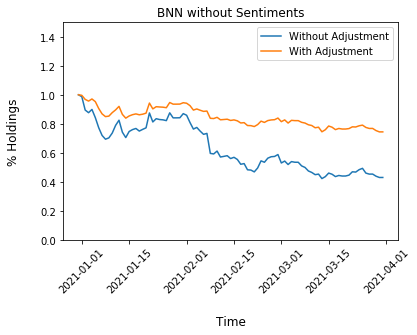

In [71]:
datePlot = [data.date.tolist()[0]- timedelta(days=1),] + data.date.tolist()
plotHoldings_without_adj = pd.Series(returns_without_adj, index = datePlot)
plotHoldings_with_adj = pd.Series(returns_with_adj, index = datePlot)

plt.plot(plotHoldings_without_adj, label = "Without Adjustment")
plt.plot(plotHoldings_with_adj, label = "With Adjustment")
plt.xticks(rotation = 45)
plt.ylim(bottom = 0, top = 1.5)
plt.ylabel("% Holdings", labelpad = 20, fontsize = 12)
plt.xlabel("Time", labelpad = 20, fontsize = 12)
plt.title("BNN without Sentiments")
plt.legend()
plt.show()

## With Sentiments

**1. Create Lags**

In [6]:
feature_lags = {"Adj_Close_BTC-USD" : 2, 
                'Open_BTC-USD': 1, 
                'Low_BTC-USD': 1, 
                'High_BTC-USD': 1,
                "Volume_BTC-USD" : 1, 
                "Adj_Close_SPY" : 1,
                "Adj_Close_GLD" : 1,
                "Adj_Close_CHFUSD=X" : 1,
                "Adj_Close_CNYUSD=X" : 1,
                "Adj_Close_EURUSD=X" : 1,
                "Adj_Close_GBPUSD=X" : 1,
                "Adj_Close_JPYUSD=X" : 1,
                "blockchain_transactions_per_block" : 1,
                "blockchain_hash_rates" : 1,
                "coindesk_sentiment" : 1,
                "num_of_coindesk_posts" : 1,
                "reddit_comments_sentiments" : 1,
                "top_50_reddit_posts_sentiments" : 1}

data = lag(df, feature_lags)

**2. Handle Train-test split**

In [7]:
data = data[data["date"] >= "1/1/2021"]

train = data[data["date"] <= "2021-03-10"]
test = data[(data["date"] > "2021-03-10") & (data["date"] <= "2021-04-5")]

X_train = train.drop(["date", "class_y"], axis = 1)
y_train = train["class_y"]

X_test = test.drop(["date", "class_y"], axis = 1)
y_test = test["class_y"]

In [8]:
X_train.head()

,Adj_Close_BTC-USD_lag1,Adj_Close_BTC-USD_lag2,Open_BTC-USD_lag1,Low_BTC-USD_lag1,High_BTC-USD_lag1,Volume_BTC-USD_lag1,Adj_Close_SPY_lag1,Adj_Close_GLD_lag1,Adj_Close_CHFUSD=X_lag1,Adj_Close_CNYUSD=X_lag1,Adj_Close_EURUSD=X_lag1,Adj_Close_GBPUSD=X_lag1,Adj_Close_JPYUSD=X_lag1,blockchain_transactions_per_block_lag1,blockchain_hash_rates_lag1,coindesk_sentiment_lag1,num_of_coindesk_posts_lag1,reddit_comments_sentiments_lag1,top_50_reddit_posts_sentiments_lag1
18,29001.72070,28840.95313,28841.57422,28201.99219,29244.87695,4.675496e+10,372.659454,178.360001,1.134327,0.153323,1.229989648,1.363066,0.009697,2077.819277,137514350.9,0.235017,18.0,0.127256,0.466726
19,29374.15234,29001.72070,28994.00977,28803.58594,29600.62695,4.073030e+10,372.659454,178.360001,1.113462,0.153099,1.218026876,1.367301,0.009687,1732.080537,142734576.9,0.254295,18.0,0.144794,0.551627
20,32127.26758,29374.15234,29376.45508,29091.18164,33155.11719,6.786542e+10,372.659454,178.360001,1.113462,0.153099,1.218026876,1.367301,0.009687,1967.622517,143322827.6,0.118618,6.0,0.242964,0.538810
21,32782.02344,32127.26758,32129.40820,32052.31641,34608.55859,7.866524e+10,372.659454,178.360001,1.113462,0.153099,1.218026876,1.367301,0.009687,2272.886076,145103346.2,0.194716,5.0,0.139765,0.379505
22,31971.91406,32782.02344,32810.94922,28722.75586,33440.21875,8.116348e+10,367.586090,182.330002,1.132375,0.153092,1.225069761,1.368420,0.009686,2160.312139,146350014.1,0.209840,14.0,0.177962,0.235787


**3. Standardise dataset and transform to tensors**

In [9]:
Xtrain_tensor, Xtest_tensor, Ytrain_tensor, Ytest_tensor = scale_and_convert_to_tensor(X_train, X_test, y_train, y_test)

print("X train tensor",Xtrain_tensor.shape)
print("Y train tensor",Ytrain_tensor.shape)
print("X test tensor",Xtest_tensor.shape)
print("Y test tensor",Ytest_tensor.shape)

X train tensor torch.Size([69, 19])
Y train tensor torch.Size([69])
X test tensor torch.Size([21, 19])
Y test tensor torch.Size([21])


**4. Perform Gridsearch**

In [87]:
### Hyperparameter Tuning --> find best parameters
train_roc_auc_list = []
test_roc_auc_list = []
combination = []

learning_param_list = pd.Series(np.linspace(0.001,0.5,50)).apply(lambda x: round(x,3))
kl_weight =  pd.Series(np.linspace(0.001,0.5,50)).apply(lambda x: round(x,3))
layers_list = ([32,16],[32,8],[32,16,8],[32,20,10])

for layer in layers_list:
    print("--- Layer: ", layer)
    for lr in learning_param_list:
        print("-- Learning Param: ", lr)
        for kl in kl_weight:
            combination.append("layer: {} lr: {} kl: {}".format(layer,lr,kl))
            _ , _, _, train_roc_auc, test_roc_auc, _ = train_model_and_evaluate_classification(Xtrain_tensor, Ytrain_tensor, Xtest_tensor, Ytest_tensor, layer, learning_param = lr, kl_weight = kl, steps = 100, printStep = False)
            train_roc_auc_list.append(train_roc_auc)
            test_roc_auc_list.append(test_roc_auc)
            
print("Complete")

--- Layer:  [32, 16]
-- Learning Param:  0.001
-- Learning Param:  0.011
-- Learning Param:  0.021
-- Learning Param:  0.032
-- Learning Param:  0.042
-- Learning Param:  0.052
-- Learning Param:  0.062
-- Learning Param:  0.072
-- Learning Param:  0.082
-- Learning Param:  0.093
-- Learning Param:  0.103
-- Learning Param:  0.113
-- Learning Param:  0.123
-- Learning Param:  0.133
-- Learning Param:  0.144
-- Learning Param:  0.154
-- Learning Param:  0.164
-- Learning Param:  0.174
-- Learning Param:  0.184
-- Learning Param:  0.194
-- Learning Param:  0.205
-- Learning Param:  0.215
-- Learning Param:  0.225
-- Learning Param:  0.235
-- Learning Param:  0.245
-- Learning Param:  0.256
-- Learning Param:  0.266
-- Learning Param:  0.276
-- Learning Param:  0.286
-- Learning Param:  0.296
-- Learning Param:  0.307
-- Learning Param:  0.317
-- Learning Param:  0.327
-- Learning Param:  0.337
-- Learning Param:  0.347
-- Learning Param:  0.357
-- Learning Param:  0.368
-- Learning Param

In [88]:
results = pd.DataFrame({"Combination": combination,"Train AUC":train_roc_auc_list, "Test AUC":test_roc_auc_list})
results.to_csv("Combinations_classification_withSentiments&lagged2.csv")

## Find the hyperparameters with gives the lowest test RMSE
results[results['Test AUC'] ==  results['Test AUC'].max()]['Combination']

1028    layer: [32, 16] lr: 0.205 kl: 0.286
Name: Combination, dtype: object

In [13]:
layer = [32, 16]
lr = 0.205
kl = 0.286

_ , _, _, train_roc_auc, test_roc_auc, _ = train_model_and_evaluate_classification(Xtrain_tensor, Ytrain_tensor, Xtest_tensor, Ytest_tensor, layer, learning_param = lr, kl_weight = kl, steps = 100, printStep = False)
print("Train AUC: ",train_roc_auc)
print("Test AUC: ",test_roc_auc)

Train AUC:  0.9707130730050935
Test AUC:  0.9045454545454545


**5. Retrain the model with selected hyperparameters and all data available**

In [14]:
## Obtain all available data
x_refit = data.drop(["date", "class_y"], axis = 1)
y_refit = data["class_y"]

### Used helper standardise function to create test and train but Xtrain_tensor is equal to Xtest_tensor
Xtrain_tensor, Xtest_tensor, Ytrain_tensor, Ytest_tensor = scale_and_convert_to_tensor(x_refit, x_refit, y_refit, y_refit)

In [15]:
model, y_predict = train_model(Xtrain_tensor, Ytrain_tensor, layers = layer, learning_param = lr, kl_weight = kl, steps = 100)        

**6. Backtesting**

In [16]:
#pd.DataFrame(y_predict).to_csv("out.csv")

In [20]:
returns_without_adj = backtest_regression_noSentiment(list(y_predict), 
                                                      data.date.tolist(), 
                                                      "BNN_classification_with_sentiment_without_adj")

In [21]:
# weighted sentiments
sentiments = df[df["date"].isin(data.date)]
sentiments = sentiments["reddit_comments_sentiments"] + sentiments["top_50_reddit_posts_sentiments"]
sentiments = ["positive" if x > np.mean(sentiments) else "negative" for x in sentiments]

returns_with_adj = backtest_regression_WithSentiment(list(y_predict), 
                                  data.date.tolist(), 
                                  sentiments, "BNN_classification_with_sentiment_with_adj")

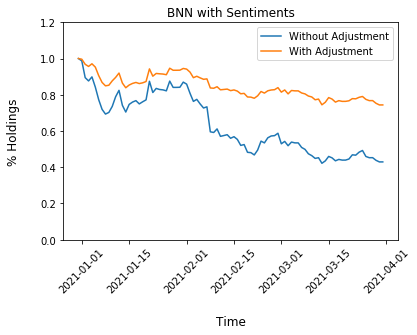

In [22]:
datePlot = [data.date.tolist()[0]- timedelta(days=1),] + data.date.tolist()
plotHoldings_without_adj = pd.Series(returns_without_adj, index = datePlot)
plotHoldings_with_adj = pd.Series(returns_with_adj, index = datePlot)

plt.plot(plotHoldings_without_adj, label = "Without Adjustment")
plt.plot(plotHoldings_with_adj, label = "With Adjustment")
plt.xticks(rotation = 45)
plt.ylim(bottom = 0, top = 1.2)
plt.ylabel("% Holdings", labelpad = 20, fontsize = 12)
plt.xlabel("Time", labelpad = 20, fontsize = 12)
plt.title("BNN with Sentiments")
plt.legend()
plt.show()